**Extract Trained Models for Evaluation**

In [17]:
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# Load Datasets from Cache
train_inputs = pd.read_csv('../cache/train_inputs.csv')
val_inputs = pd.read_csv('../cache/val_inputs.csv')
train_targets = pd.read_csv('../cache/train_targets.csv')
val_targets = pd.read_csv('../cache/val_targets.csv')

In [4]:
train_inputs = train_inputs.drop(columns=['Date'])
val_inputs = val_inputs.drop(columns=['Date'])

In [31]:
# Load the Decision Tree model
tree = joblib.load('../cache/decision_tree_model.joblib')
print("Decision Tree model loaded.")

# Load the Random Forest model
rf_old = joblib.load('../cache/random_forest_model.joblib')
print("Random Forest model loaded.")

Decision Tree model loaded.
Random Forest model loaded.


In [32]:
# Compute metrics for Decision Tree
tree_train_rmse = root_mean_squared_error(train_targets, tree.predict(train_inputs))
tree_val_rmse = root_mean_squared_error(val_targets, tree.predict(val_inputs))

# Compute metrics for Random Forest
rf_train_rmse = root_mean_squared_error(train_targets, rf_old.predict(train_inputs))
rf_val_rmse = root_mean_squared_error(val_targets, rf_old.predict(val_inputs))

In [9]:
# Create a comparison DataFrame
metrics_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest'],
    'Train RMSE': [tree_train_rmse, rf_train_rmse],
    'Validation RMSE': [tree_val_rmse, rf_val_rmse]
})

In [10]:
print("Model Comparison:")
print(metrics_df)

Model Comparison:
           Model    Train RMSE  Validation RMSE
0  Decision Tree  2.056476e-17      5355.690313
1  Random Forest  1.419339e+03      3879.909707


<Figure size 800x600 with 0 Axes>

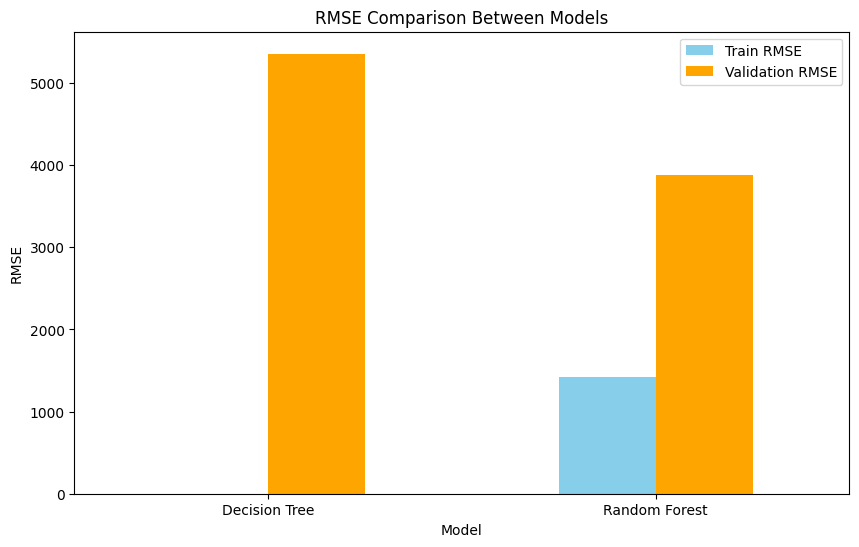

In [33]:
# Plot comparison bar chart
plt.figure(figsize=(8, 6))
metrics_df.set_index('Model')[['Train RMSE', 'Validation RMSE']].plot(kind='bar', color=['skyblue', 'orange'], figsize=(10, 6))
plt.title('RMSE Comparison Between Models')
plt.ylabel('RMSE')
plt.xticks(rotation=0)
plt.show()

In [34]:
# Ensure val_targets and predictions are 1-dimensional
val_targets = val_targets.values.flatten() if isinstance(val_targets, pd.DataFrame) else val_targets.flatten()
tree_predictions = tree.predict(val_inputs).flatten()
rf_predictions = rf_old.predict(val_inputs).flatten()

# Calculate residuals
tree_residuals = val_targets - tree_predictions
rf_residuals = val_targets - rf_predictions

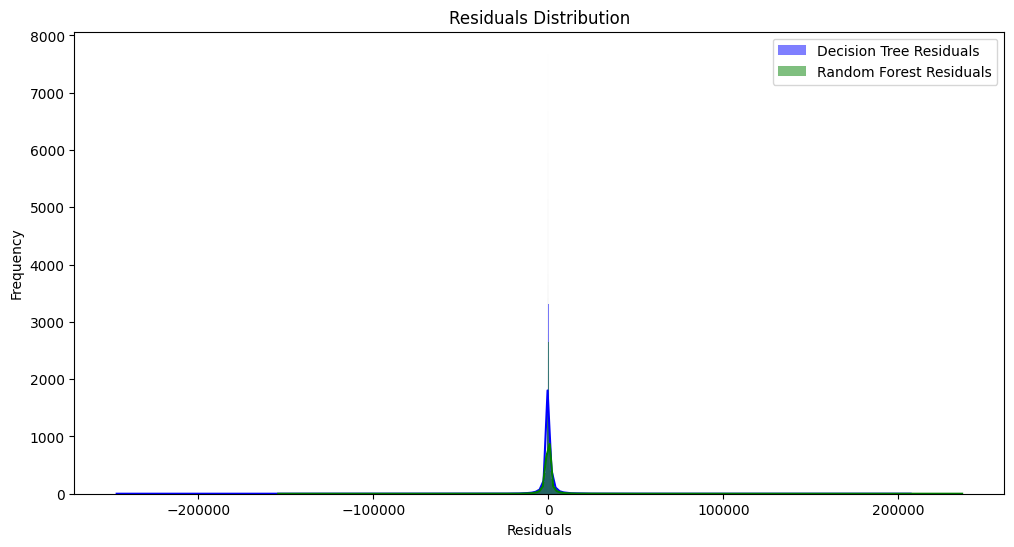

In [15]:
# Residual Distribution Plot
plt.figure(figsize=(12, 6))

# Plotting both residuals in a single graph
sns.histplot(tree_residuals, kde=True, color='blue', label='Decision Tree Residuals', alpha=0.5)
sns.histplot(rf_residuals, kde=True, color='green', label='Random Forest Residuals', alpha=0.5)

plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

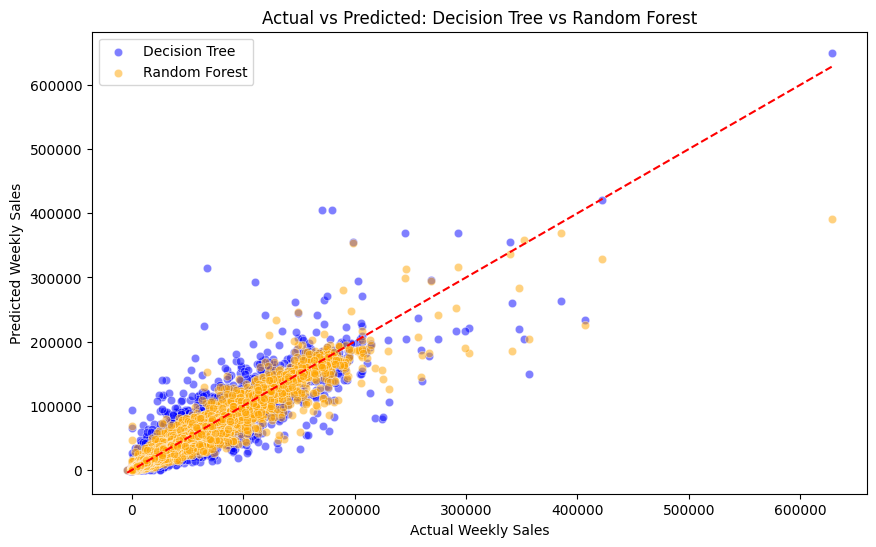

In [ ]:
# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.scatterplot(x=val_targets, y=tree.predict(val_inputs), label='Decision Tree', alpha=0.5, color='blue')
sns.scatterplot(x=val_targets, y=rf_old.predict(val_inputs), label='Random Forest', alpha=0.5, color='orange')
plt.plot([val_targets.min(), val_targets.max()], [val_targets.min(), val_targets.max()], 'r--')
plt.title("Actual vs Predicted: Decision Tree vs Random Forest")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.legend()
plt.show()

**Among the 2 models Random Forest avoids Data Overfitting during training and has lesser RMSE ;thus is our choice of a better model among the 2 for hyperparameter tuning**

In [ ]:
# Step 1: Define another Random Forest Model
rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=None)

In [19]:
# Step 2: Define the hyperparameter grid
param_distributions = {
    'n_estimators': [10, 50, 100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15, 20, 25, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15],     # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6],        # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider at each split
    'bootstrap': [True, False]               # Whether to use bootstrap samples when building trees
}

In [20]:
# Step 3: Define the random search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter combinations to try
    scoring='neg_root_mean_squared_error',  # Scoring metric
    cv=3,  # Number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [21]:
# Step 4: Fit the random search on the training data
print("Running Random Search...")
random_search.fit(train_inputs, train_targets)

Running Random Search...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/I

[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.2min
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.2min
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 1.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.5min
[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.5min
[CV] END bootstrap=False, max_depth=5, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time= 1.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=  18.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=  17.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time=  16.9s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time= 2.4min
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time= 2.4min
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=50; total time= 2.4min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.8min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.8min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.8min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=10; total time=  43.3s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=10; total time=  43.7s
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=10; total time=  43.6s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   7.7s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   7.8s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=10; total time=   7.9s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 4.1min
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 4.1min
[CV] END bootstrap=True, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 4.1min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.3min
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 2.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time= 8.8min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time= 8.8min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time= 8.8min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   9.5s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   9.7s
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   9.9s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.6min
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time= 1.6min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  47.9s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  48.4s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=6, min_samples_split=2, n_estimators=50; total time=  49.7s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=15, n_estimators=100; total time= 1.4min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 5.5min
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 5.5min
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time= 5.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  34.0s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  34.1s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time=  34.7s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=200; total time= 2.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=200; total time= 2.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=15, n_estimators=200; total time= 2.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time= 2.9min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time= 2.9min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=200; total time= 2.9min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 1.0min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time= 1.0min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time= 6.1min
[CV] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time= 6.1min
[CV] END bootstrap=True, max_depth=5, max_features=None, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time= 6.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=14.9min
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=15.0min
[CV] END bootstrap=True, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=15.0min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time= 1.1min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time= 1.1min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=15, n_estimators=10; total time= 1.1min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=100; total time=  43.3s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=100; total time=  43.1s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=100; total time=  42.7s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=15, n_estimators=200; total time= 2.2min
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=15, n_estimators=200; total time= 2.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=1, min_samples_split=15, n_estimators=200; total time= 2.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=   9.9s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  10.4s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=25, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time=  10.6s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 4.2min
[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time= 6.9min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 4.2min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time= 4.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/I

[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time= 6.8min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time= 6.8min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.4min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=  59.7s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time=  59.8s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=100; total time= 1.0min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.7min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.7min
[CV] END bootstrap=False, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.7min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 9.6min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 9.6min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 9.6min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.5min
[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time= 1.3min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time= 1.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=100; total time= 1.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=11.3min
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=11.3min
[CV] END bootstrap=False, max_depth=25, max_features=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=11.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time=14.3min
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time=14.3min
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time=14.3min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=  17.0s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=  15.8s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=2, min_samples_split=15, n_estimators=10; total time=  15.9s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.5min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.5min
[CV] END bootstrap=True, max_depth=5, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 1.6min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 1.2min
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 1.2min
[CV] END bootstrap=False, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=50; total time= 1.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  37.7s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  37.4s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=  38.2s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  54.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  55.2s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total time=  55.0s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time= 5.0min
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time= 5.0min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=15, n_estimators=300; total time= 5.0min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time= 1.1min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time= 1.1min
[CV] END bootstrap=False, max_depth=20, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=10; total time= 1.0min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  47.1s
[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  46.8s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time=19.0min
[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=10; total time=  47.4s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time=19.1min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=None, max_features=None, min_samples_leaf=6, min_samples_split=5, n_estimators=300; total time=19.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  33.6s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  33.3s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time=  34.5s


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time= 1.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time= 1.2min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=50; total time= 1.1min


/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.2min
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.2min
[CV] END bootstrap=False, max_depth=10, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.1min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 6.7min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 6.7min
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 6.7min
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 3.9min
[CV] END bootstrap=False, max_depth

/Users/admukhop/Documents/My Folder/IISC/AUG-DEC Sem/project/.venv/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=0),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [10, 50, 100, 200,
                                                         300]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [22]:
# Step 5: Extract the best parameters and performance
best_params = random_search.best_params_
best_score = -random_search.best_score_  # Convert negative RMSE to positive
print(f"Best Parameters: {best_params}")
print(f"Best RMSE (Validation): {best_score:.4f}")

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 25, 'bootstrap': True}
Best RMSE (Validation): 4092.1642


In [23]:
# Step 6: Evaluate the best model on the validation set
best_model = random_search.best_estimator_
val_preds = best_model.predict(val_inputs)
val_rmse = root_mean_squared_error(val_targets, val_preds)
print(f"Validation RMSE of Best Model: {val_rmse:.4f}")

Validation RMSE of Best Model: 3917.1883


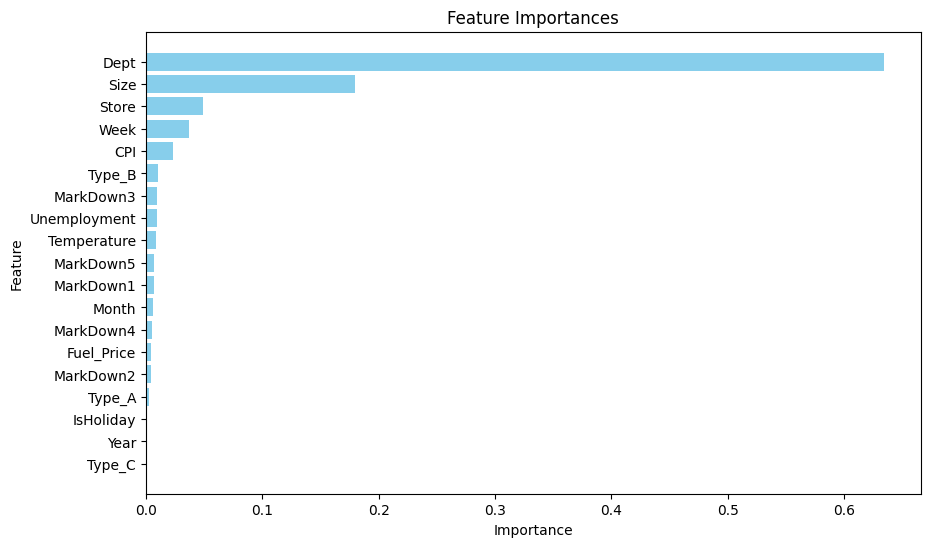

In [27]:
# Step7: Plotting feature importance for the best model
feature_importances = pd.DataFrame({
    'Feature': train_inputs.columns,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.show()

Visualizing predictions vs actual values By the Best Model...


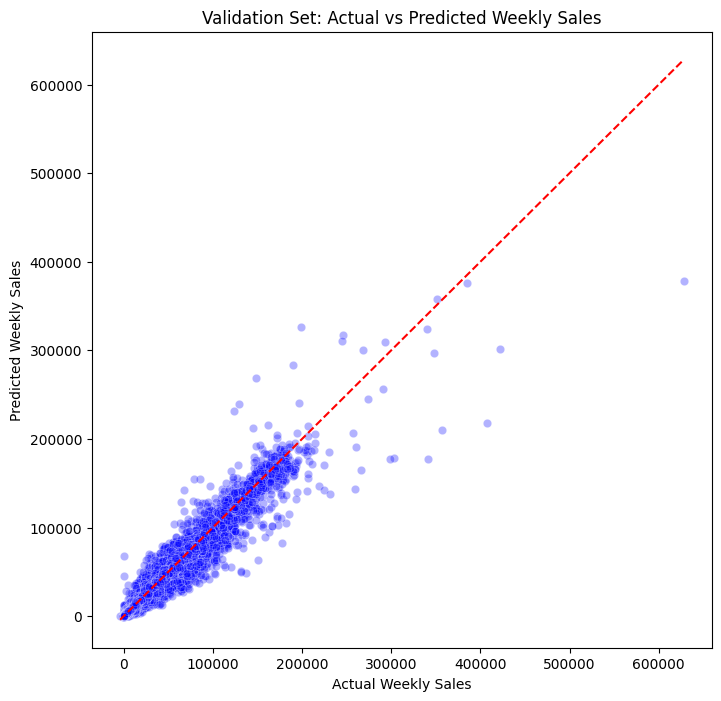

In [29]:
# Validation Scatter Plot
print("Visualizing predictions vs actual values By the Best Model...")
plt.figure(figsize=(8, 8))
sns.scatterplot(x=val_targets, y=val_preds, alpha=0.3, color='blue')
plt.plot([val_targets.min(), val_targets.max()], [val_targets.min(), val_targets.max()], color='red', linestyle='--')
plt.title("Validation Set: Actual vs Predicted Weekly Sales")
plt.xlabel("Actual Weekly Sales")
plt.ylabel("Predicted Weekly Sales")
plt.show()


In [37]:
val_targets = val_targets.values.flatten() if isinstance(val_targets, pd.DataFrame) else val_targets.flatten()
rf_predictions = rf_old.predict(val_inputs)

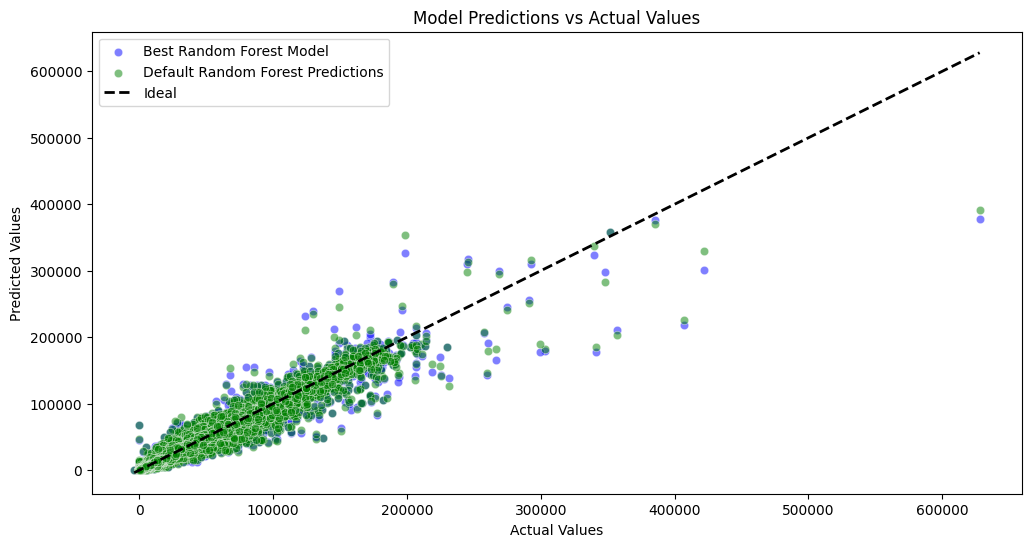

In [38]:
# Create a scatter plot to compare predictions
plt.figure(figsize=(12, 6))

# Plot first model (Decision Tree) predictions
sns.scatterplot(x=val_targets, y=val_preds, alpha=0.5, color='blue', label='Best Random Forest Model')

# Plot best model (Random Forest) predictions
sns.scatterplot(x=val_targets, y=rf_predictions, alpha=0.5, color='green', label='Default Random Forest Predictions')

# Plot the ideal line
plt.plot([val_targets.min(), val_targets.max()], [val_targets.min(), val_targets.max()], 'k--', lw=2, label='Ideal')

plt.title('Model Predictions vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

**Random Search failed to reduce the RMSE which could be due to one of the following reasons**

Overfitting Potential: Hyperparameter tuning can sometimes lead to overfitting, where the model becomes too tailored to the training data and loses its ability to generalize to unseen data. This is particularly possible if the hyperparameters selected during tuning are too complex or specific to the training set.

Validation Strategy: The increase in RMSE could suggest a potential misalignment between the cross-validation setup used during hyperparameter tuning and the test data characteristics. Ensuring that the cross-validation process accurately reflects the test data distribution and potential variability is crucial for reliable tuning outcomes.

Hyperparameter Space: The search space and selected hyperparameter ranges might have inadvertently led to configurations that are not optimal for the test data. 

**To fix this issue**

Feature and Data Considerations: The feature set used, alongside data quality and preprocessing steps, can significantly impact model performance. Reviewing feature importance and ensuring data consistency across training, validation, and test sets can provide further insights.

Iterative Refinement: Model tuning is often an iterative process. It might be beneficial to conduct further iterations of tuning with refined search spaces or alternative validation strategies, such as nested cross-validation, to achieve a more generalizable model.